# Abstract
본 사전 과제는 IMDB 데이터셋에 대해 Sentiment Analysis 하는 binary classfication 모델을 훈련 및 성능을 평가합니다.<br>
본 과제에서는 "harshhmaniya/fine-tuned-bert-imdb-sentiment-analysis"을 pre-trained 모델로 선정하였습니다.<br>
(https://huggingface.co/harshhmaniya/fine-tuned-bert-imdb-sentiment-analysis)<br>
해당 pre-trained 모델은 IMDB 데이터셋을 사용하여 Full Supervised 학습을 진행하여, 해당 목적에 더 높은 정확도를 보장할 수 있어 선택했습니다.<br>
<br>
본 과제에서 가장 핵심적으로 해결해야 할 문제는 IMDB 데이터셋의 unsupervised 데이터의 활용입니다.<br>
unsupervised 데이터양은 전체 데이터의 50%이며, 이를 활용하여 모델의 성능을 이끌어내는것이 중요하다고 생각합니다.<br>
label이 없는 데이터의 활용 방안으로 self-supervised learning, contrastive learning, pseudo-labeling을 고려하였으며, 컴퓨팅 자원과 시간을 고려하여 contrastive learning 방안을 채택하였습니다.<br>
contrastive learning은 BYOL-Style 기법을 활용했습니다. BYOL (Bootstrap Your Own Latent)은 representation을 스스로 증강(bootstrap)하는 self-supervised learning 방법입니다.<br>
본 과제에서는 unsupervised 데이터를 활용하여 BYOL-style contrastive learning을 수행하고, encoder를 더욱 표현력 있게 학습시켰습니다.
그 후 downstream fine tunning(LoRA 활용)을 통해 labeled 데이터를 학습합니다.<br>
이를 통해 labeled 데이터만으로 학습했을 때보다, encoder의 generalization 성능이 향상될 것으로 기대합니다.
<br><br>
pre-trained 모델을 label 데이터에 epoch 4만큼 파인튜닝한 후, contrastive learning을 진행하였습니다. 성능지표로는 binary classification 문제이므로 F1-Score, Accuracy, Confusion Matrix을 활용하였습니다. <br>
F1-score은 pre-trained 모델 0.9122, label 데이터 파인튜닝 모델 0.9225, unsupervised 데이터 파인튜닝 모델 중, BYOL-style 모델 0.886, SimCSE 모델 0.89결과를 얻었습니다.<br>

Contrastive learning을 적용한 후, 전체 F1-score가 pre-trained 모델 대비 다소 낮아졌습니다 (0.886 vs 0.89 vs 0.9122).<br>
이는 contrastive learning 과정에서 encoder의 표현이 일부 task-specific feature를 잃거나, downstream task (sentiment analysis)에 최적화되지 않았을 가능성이 있습니다.
<br>주요 원인은 contrastive learning이 downstream task와 완전히 일치하지 않아, encoder가 분류에 유리한 feature를 일부 희생했을 수 있다는 점과 하이퍼파라미터 조정 부족이 있습니다.

<hr>

# 모델 성능을 향상시킬 수 있는 아이디어, Future work
제가 제안한 contrastive alignment 기반 감성 분석 모델의 성능을 바탕으로, 보다 일반화 가능하고 효율적인 모델을 구현하기 위해 다음과 같은 세 가지 아이디어를 제안합니다.
1. Pseudo-labeling을 통한 준지도 학습

fine-tuning된 모델을 이용해 unlabeled IMDb 리뷰에 대해 pseudo-label을 생성하고, 이를 기존 labeled 데이터와 함께 supervised training에 통합합니다. 이렇게 하면 unlabeled 데이터로부터 학습 신호를 확장하여, 원래의 labeled 데이터셋에 과적합되는 현상을 완화할 수 있습니다. pseudo-labeled 데이터에 대해서도 cross-entropy loss를 계산함으로써, unlabeled 데이터를 값진 학습 자원으로 전환할 수 있습니다.<br>
<br>
2. multi-task learning

multi-task learning을 통해 contrastive alignment와 supervised classification을 동시에 학습하는 방식을 제안합니다. 
기존에는 두 단계를 순차적으로 수행했지만, 아래와 같은 형태의 joint loss를 설계하여 unlabeled 데이터와 labeled 데이터를 같은 배치에서 동시에 활용할 수 있습니다:
    
$\text{Total Loss} = \text{Contrastive Loss} + \lambda \cdot \text{Classification Loss}$
    
여기서 $\lambda$는 두 손실의 균형을 맞추는 하이퍼파라미터입니다. 이 접근법은 encoder가 두 가지 태스크로부터 동시에 피드백을 받아, 보다 일반화된 감성 분석 성능을 기대할 수 있습니다.
<br><br>
3. LLM을 활용한 labeling

SOTA LLLM은 sentiment analysis을 빠르고 정확하게 진행할 수 있습니다. 산업에 바로 적용하기 위해서는 unsupervised 데이터를 LLM을 활용하여 빠르게 labeling하는 것이 효율적이고 유리할 수 있습니다.

In [10]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# IMDb 데이터셋 로드
dataset = load_dataset("imdb")

In [5]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


#### 데이터 중 "&lt;br&gt;"이 존재하지만 BERT 계열 모델은 robust하게 토큰 단위로 입력을 처리하여 실제 문맥 인식에 큰 영향을 주지 않음

### Pre-trained 모델 성능 확인
pre-trained 모델이 tensorflow로 학습되어 from_tf=True(7번 라인)을 사용

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "harshhmaniya/fine-tuned-bert-imdb-sentiment-analysis"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, from_tf=True)

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [4]:
# 토크나이즈 함수 정의
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

# 훈련 및 테스트 데이터 토크나이즈
tokenized_train = dataset["train"].map(tokenize_function, batched=True)
tokenized_test = dataset["test"].map(tokenize_function, batched=True)

# 필요한 열만 선택하고 포맷 설정
tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [5]:
# 모델을 평가 모드로 설정
model.eval()

# 디바이스 설정 (GPU 사용 가능 시 GPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 예측 및 실제 라벨 저장 리스트
preds = []
labels = []

# 배치 단위로 예측 수행
for batch in torch.utils.data.DataLoader(tokenized_test, batch_size=32, num_workers=2):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels.extend(batch["label"].cpu().numpy())  # to CPU에서 변환

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())


In [6]:
# 정확도 및 F1 점수 계산
accuracy = accuracy_score(labels, preds)
f1 = f1_score(labels, preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9099
F1 Score: 0.9122


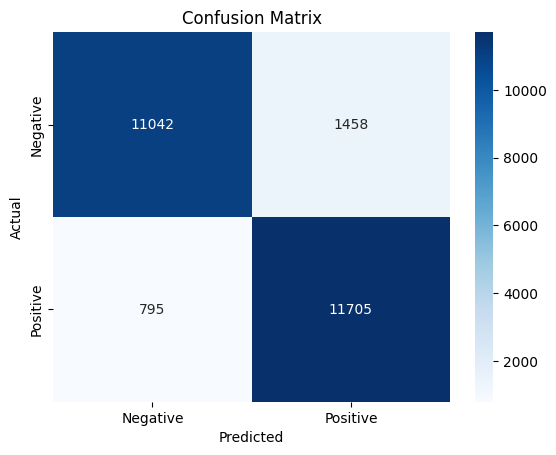

In [7]:
# 혼동 행렬 계산
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [8]:
# 분류 리포트 출력
print("Classification Report:")
print(classification_report(labels, preds, target_names=['Negative', 'Positive']))

Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.88      0.91     12500
    Positive       0.89      0.94      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000



<hr>

### labeled 데이터를 활용하여 파인튜닝(epoch 4)

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer


from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)  # 예측된 라벨
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc}

# 모델 학습
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    report_to=None
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

trained_model = trainer.model


C:\Users\gnssl\AppData\Local\Temp\ipykernel_19004\2766952800.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.190900,0.270464,0.904000
2,0.080900,0.364319,0.913720
3,0.037000,0.421037,0.921080
4,0.016000,0.461533,0.922360


In [10]:
trained_model.save_pretrained(r"D:\labeled_fintuned_model")    # 로컬에 저장
tokenizer.save_pretrained(r"D:\labeled_fintune_model")        # 토크나이저도 저장

('D:\\labeled_fintune_model\\tokenizer_config.json',
 'D:\\labeled_fintune_model\\special_tokens_map.json',
 'D:\\labeled_fintune_model\\vocab.txt',
 'D:\\labeled_fintune_model\\added_tokens.json',
 'D:\\labeled_fintune_model\\tokenizer.json')

In [11]:
# 훈련된 모델 평가
trained_model = trainer.model
trained_model.eval()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)

preds = []
labels = []

for batch in torch.utils.data.DataLoader(tokenized_test, batch_size=32, num_workers=2):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels.extend(batch["label"].cpu().numpy())

    with torch.no_grad():
        outputs = trained_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())

In [12]:
# 정확도 및 F1 점수 계산
accuracy = accuracy_score(labels, preds)
f1 = f1_score(labels, preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9224
F1 Score: 0.9225


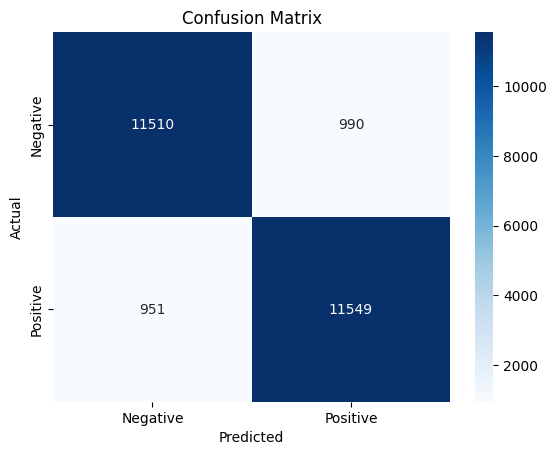

In [13]:
# 혼동 행렬 계산
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<hr>

# BYOL-Style을 활용한 unsupervised 데이터 학습

## BYOL-Style Contrastive Pre-training (Self-Supervised Phase)

#### teacher-student momentum encoder (EMA) 구조를 활용

* 데이터셋 : IMDB의 unsupervised 데이터
* 구성 :
    * student encoder: 온라인으로 학습되는 모델
    * teacher encoder: momentum update로만 갱신되는 teacher (EMA 적용)

* 학습 방식 : 
    * student는 dropout이 켜진 상태 (view1)
    * teacher는 dropout이 꺼진 상태 (view2)
    * 두 embedding을 normalize 후 cosine similarity 기반 contrastive loss (BYOL-style) 계산
    * student encoder는 loss로 update
    * teacher encoder는 EMA로 student를 따라감

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer, AutoConfig
import copy

# Hyperparameters
batch_size = 32
num_epochs = 3
temperature = 0.05
ema_decay = 0.99  # teacher update momentum

# Load IMDB dataset
dataset = load_dataset("imdb")
unsupervised_texts = dataset["unsupervised"]["text"]

# Load encoder config
config = AutoConfig.from_pretrained(r"D:\labeled_fintuned_model", local_files_only=True)
config.output_hidden_states = False

# Online encoder (student)
online_encoder = AutoModel.from_pretrained(
    r"D:\labeled_fintuned_model",
    config=config,
    local_files_only=True
).to("cuda")
online_encoder.train()

# Momentum encoder (teacher): initialized as a deepcopy of online encoder
momentum_encoder = copy.deepcopy(online_encoder).eval()
for param in momentum_encoder.parameters():
    param.requires_grad = False  # teacher는 update 안함 (EMA로만 갱신)

tokenizer = AutoTokenizer.from_pretrained(
    r"D:\labeled_fintune_model",
    local_files_only=True
)

# Dataset & Loader
class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=max_length)

    def __getitem__(self, idx):
        return {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}

    def __len__(self):
        return len(self.encodings["input_ids"])

unlabeled_dataset = UnlabeledDataset(unsupervised_texts, tokenizer)
unlabeled_loader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

optimizer = torch.optim.AdamW(online_encoder.parameters(), lr=2e-5)

def update_momentum_encoder(student, teacher, m=ema_decay):
    for param_s, param_t in zip(student.parameters(), teacher.parameters()):
        param_t.data = param_t.data * m + param_s.data * (1.0 - m)

for epoch in range(num_epochs):
    total_loss = 0
    for batch in tqdm(unlabeled_loader, desc=f"BYOL Epoch {epoch+1}"):
        input_ids = batch["input_ids"].cuda()
        attention_mask = batch["attention_mask"].cuda()

        # Student (online) forward pass (view 1)
        online_encoder.train()  # dropout ON
        embeds_student = online_encoder(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        embeds_student = F.normalize(embeds_student, dim=1)

        # Teacher (momentum) forward pass (view 2, no dropout)
        with torch.no_grad():
            momentum_encoder.eval()  # dropout OFF
            embeds_teacher = momentum_encoder(input_ids=input_ids, attention_mask=attention_mask).pooler_output
            embeds_teacher = F.normalize(embeds_teacher, dim=1)

        # BYOL loss (cosine similarity loss)
        similarity = torch.matmul(embeds_student, embeds_teacher.T) / temperature
        labels = torch.arange(input_ids.size(0), device=embeds_student.device)
        loss = F.cross_entropy(similarity, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update teacher (momentum encoder)
        update_momentum_encoder(online_encoder, momentum_encoder)

        total_loss += loss.item()

    avg_loss = total_loss / len(unlabeled_loader)
    print(f"Epoch {epoch+1} - Avg BYOL Loss: {avg_loss:.4f}")

# Save final online encoder
torch.save(online_encoder.state_dict(), "byol_encoder.pt")
print("\n 모델 저장 완료: byol_encoder.pt")


BYOL Epoch 1: 100%|████████████████████████████████████████████████████████████████| 1563/1563 [13:36<00:00,  1.92it/s]


Epoch 1 - Avg BYOL Loss: 0.6396


BYOL Epoch 2: 100%|████████████████████████████████████████████████████████████████| 1563/1563 [13:28<00:00,  1.93it/s]


Epoch 2 - Avg BYOL Loss: 0.0419


BYOL Epoch 3: 100%|████████████████████████████████████████████████████████████████| 1563/1563 [13:27<00:00,  1.94it/s]


Epoch 3 - Avg BYOL Loss: 0.0144

 모델 저장 완료: byol_encoder.pt



 Cosine 유사도 (평균): 0.9107214
MSE (평균): 0.049565833


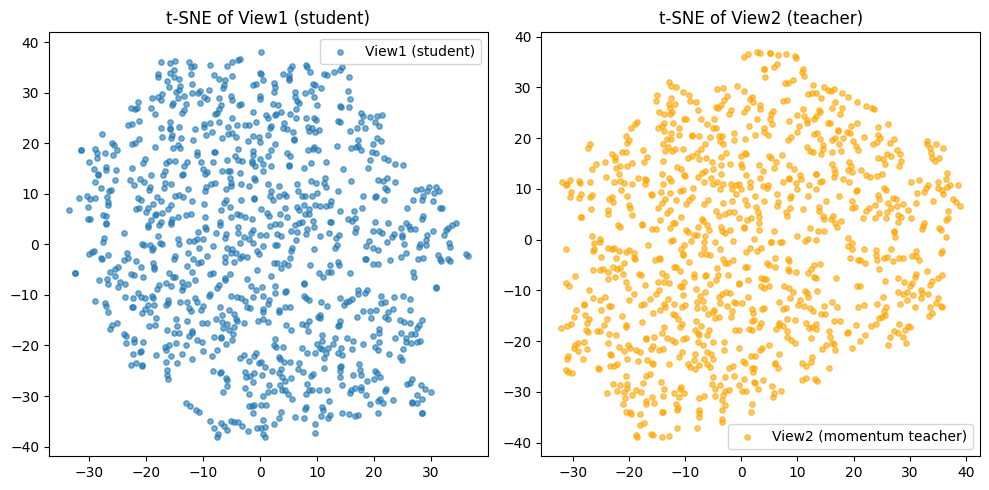

In [2]:
import torch
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# BYOL-style encoder 로드
encoder = AutoModel.from_pretrained(
    r"D:\labeled_fintuned_model",
    local_files_only=True
).to("cuda")
encoder_state_dict = torch.load("byol_encoder.pt")
encoder.load_state_dict(encoder_state_dict)
encoder.eval()

# Tokenizer 로드
tokenizer = AutoTokenizer.from_pretrained(
    r"D:\labeled_fintune_model",
    local_files_only=True
)

# 테스트 데이터 (임의로 IMDb test 데이터 일부 사용)
dataset = load_dataset("imdb")
test_texts = dataset["test"].shuffle(seed=42).select(range(1000))["text"]

# 토크나이즈
inputs = tokenizer(test_texts, truncation=True, padding="max_length", max_length=128, return_tensors="pt").to("cuda")

# view1 (dropout ON)
encoder.train()  # dropout ON
with torch.no_grad():
    embeds1 = encoder(**inputs).pooler_output.cpu().numpy()

# view2 (다시 dropout ON)
encoder.train()
with torch.no_grad():
    embeds2 = encoder(**inputs).pooler_output.cpu().numpy()

# Cosine similarity / MSE로 정렬 품질 수치 확인
cos_sim = np.sum(embeds1 * embeds2, axis=1) / (
    np.linalg.norm(embeds1, axis=1) * np.linalg.norm(embeds2, axis=1)
)
mse = np.mean((embeds1 - embeds2)**2, axis=1)

print("\n Cosine 유사도 (평균):", cos_sim.mean())
print("MSE (평균):", mse.mean())

# t-SNE 시각화
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeds1_2d = tsne.fit_transform(embeds1)
embeds2_2d = tsne.fit_transform(embeds2)

plt.figure(figsize=(10, 5))

# view1
plt.subplot(1, 2, 1)
plt.scatter(embeds1_2d[:, 0], embeds1_2d[:, 1], s=15, alpha=0.6, label="View1 (student)")
plt.title("t-SNE of View1 (student)")
plt.legend()

# view2
plt.subplot(1, 2, 2)
plt.scatter(embeds2_2d[:, 0], embeds2_2d[:, 1], s=15, alpha=0.6, color='orange', label="View2 (momentum teacher)")
plt.title("t-SNE of View2 (teacher)")
plt.legend()

plt.tight_layout()
plt.show()


Cosine 유사도가 준수함 -> view1 (student)와 view2 (teacher)의 임베딩이 거의 일치<br>
MSE (평균)이 낮음 -> 유사성 기반으로 정렬을 잘 했고, 학생-선생 임베딩이 비슷해졌음<br>
T-SNE로 두 view 분포가 전체적으로 유사한 것을 확인 가능

<hr>

## Downstream Fine-tuning (Supervised Phase)
BYOL-pretrained encoder를 labeled IMDB 데이터로 fine-tuning
<br>
#### Encoder 상위 2개 layer만 학습
* Pre-trained encoder의 강력한 표현력 활용
* 불필요한 과적합 방지
* 언어 표현의 세분화와 task-specific tuning
    * transformer encoder의 하위 layer (1~9): 문법/구문 같은 언어의 기본 구조를 학습.
    * 상위 layer (10~11): 특정 task (감정 분석, 문장 유사도 등)에 맞는 정교한 표현을 학습.
  
* LoRA 적용:
    * encoder의 일부 query, value에만 low-rank adapter 추가 → 파라미터 효율적으로 fine-tuning
    
* labeled data를 사용하여 classification head를 학습

In [3]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from peft import get_peft_model, LoraConfig, TaskType
import torch
from datasets import load_dataset
from transformers import AutoTokenizer

#  Pre-trained encoder (BYOL-style) 불러오기
model_cls = AutoModelForSequenceClassification.from_pretrained(
    r"D:\labeled_fintuned_model",
    local_files_only=True
).to("cuda")

# BYOL-style encoder로 덮어쓰기
byol_encoder_state_dict = torch.load("byol_encoder.pt")
model_cls.bert.load_state_dict(byol_encoder_state_dict)

# Encoder 일부 unfreeze (마지막 2개 layer만 학습 가능)
for name, param in model_cls.bert.named_parameters():
    if "encoder.layer.10" in name or "encoder.layer.11" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# LoRA 설정
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)
model_cls = get_peft_model(model_cls, lora_config)
print("\n 적용된 LoRA 파라미터 (encoder 일부 unfreeze):")
model_cls.print_trainable_parameters()

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    r"D:\labeled_fintune_model",
    local_files_only=True
)

# IMDB 데이터셋 (전체 학습 데이터 사용)
dataset = load_dataset("imdb")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Tokenize
def tokenize_fn(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_train = train_dataset.map(tokenize_fn, batched=True).rename_column("label", "labels").remove_columns(["text"])
tokenized_train.set_format(type="torch")

tokenized_test = test_dataset.map(tokenize_fn, batched=True).rename_column("label", "labels").remove_columns(["text"])
tokenized_test.set_format(type="torch")

# Metric
def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, f1_score
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# TrainingArguments
training_args = TrainingArguments(
    output_dir="./results_lora_encoderfreeze_byol",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    fp16=True,  
    save_strategy="no",  
    logging_steps=100
)

# Trainer
trainer = Trainer(
    model=model_cls,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Training
trainer.train()
print("\n Downstream fine-tuning (BYOL-pretrained encoder + LoRA) 완료!")

# 최종 평가
eval_results = trainer.evaluate()
print("\n 최종 성능 평가 결과:")
for metric, value in eval_results.items():
    print(f"{metric}: {value:.4f}")



 적용된 LoRA 파라미터 (encoder 일부 unfreeze):
trainable params: 296,450 || all params: 109,780,228 || trainable%: 0.2700


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

C:\Users\gnssl\AppData\Local\Temp\ipykernel_16720\797494985.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
D:\inteXvenv\lib\site-packages\transformers\utils\generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dt

Step,Training Loss
100,0.395700
200,0.230800
300,0.222100
400,0.194000
500,0.192000
600,0.185800
700,0.184600
800,0.204100
900,0.166500
1000,0.178900



 Downstream fine-tuning (BYOL-pretrained encoder + LoRA) 완료!



 최종 성능 평가 결과:
eval_loss: 0.3144
eval_accuracy: 0.8857
eval_f1: 0.8856
eval_runtime: 67.0481
eval_samples_per_second: 372.8670
eval_steps_per_second: 11.6630
epoch: 4.0000


In [4]:
from sklearn.metrics import classification_report, confusion_matrix

# 예측 수행
predictions = trainer.predict(test_dataset=tokenized_test)
pred_labels = predictions.predictions.argmax(axis=1)
true_labels = predictions.label_ids

# scikit-learn 평가
print("\n=== Classification Report ===")
print(classification_report(true_labels, pred_labels, digits=4))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(true_labels, pred_labels))


D:\inteXvenv\lib\site-packages\transformers\utils\generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(obj)
D:\inteXvenv\lib\site-packages\transformers\utils\generic.py:271: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(obj)



=== Classification Report ===
              precision    recall  f1-score   support

           0     0.8848    0.8869    0.8859     12500
           1     0.8866    0.8846    0.8856     12500

    accuracy                         0.8857     25000
   macro avg     0.8857    0.8857    0.8857     25000
weighted avg     0.8857    0.8857    0.8857     25000


=== Confusion Matrix ===
[[11086  1414]
 [ 1443 11057]]


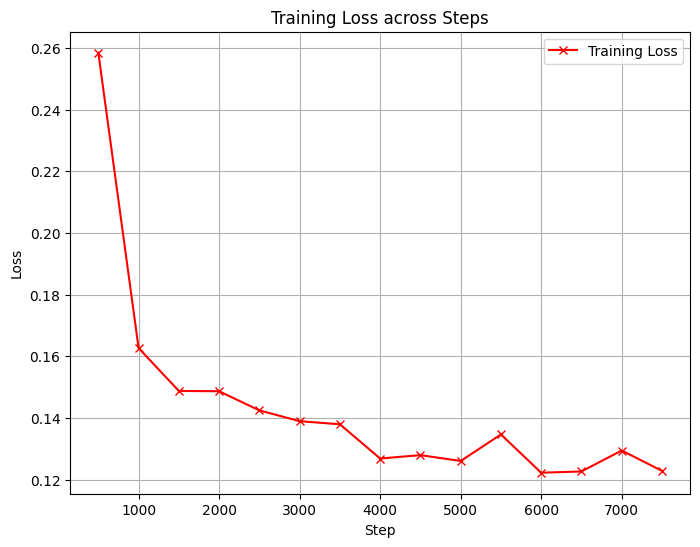

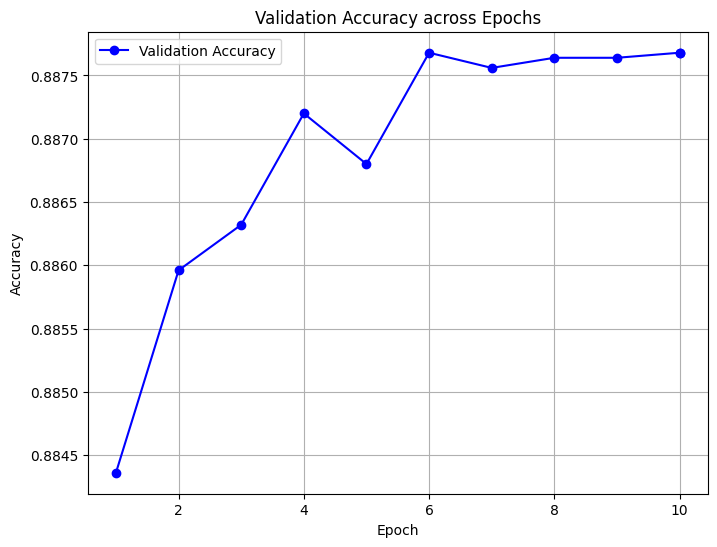

In [3]:
import matplotlib.pyplot as plt

train_steps, train_losses = [], []
eval_epochs, eval_accuracies = [], []

for log in trainer.state.log_history:
    if "loss" in log:
        train_losses.append(log["loss"])
        step = log.get("step", len(train_steps))
        train_steps.append(step)
    if "eval_accuracy" in log:
        eval_accuracies.append(log["eval_accuracy"])
        epoch = log.get("epoch", len(eval_epochs) + 1)
        eval_epochs.append(epoch)

if train_losses:
    plt.figure(figsize=(8, 6))
    plt.plot(train_steps, train_losses, marker='x', color='red', label="Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training Loss across Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

if eval_accuracies:
    plt.figure(figsize=(8, 6))
    plt.plot(eval_epochs, eval_accuracies, marker='o', color='blue', label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy across Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


<hr>

# SimCSE unsupervised 방식

## Contrastive Pre-training 단계 (Unsupervised Data로 Encoder를 Pre-train)

#### 같은 문장의 dropout으로만 positive pair 생성
* 데이터셋: IMDb의 unsupervised 데이터

* 구성:
    * student encoder: classification head를 제거한 BERT encoder

    * teacher encoder: 없음 (teacher 없이 dropout만 다르게 적용 → SimCSE-style)

* 학습 방식:
    * view1, view2: 같은 input에서 dropout이 켜진 상태로 두 번 인코딩 (augmentation)

    * 두 embedding을 normalize 후 cosine similarity 기반의 contrastive loss 계산

    * CrossEntropyLoss를 통해 같은 index 간의 similarity를 높이고, 다른 index는 낮춤

    * student encoder는 이 loss로 직접 업데이트


In [6]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer

# Load dataset
dataset = load_dataset("imdb")
unsupervised_texts = dataset["unsupervised"]["text"]

# Load base encoder (no classification head)
model = AutoModel.from_pretrained(
    r"D:\labeled_fintuned_model",
    local_files_only=True
).to("cuda")
model.train()  

tokenizer = AutoTokenizer.from_pretrained(
    r"D:\labeled_fintune_model",
    local_files_only=True
)

# Unlabeled Dataset
class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=max_length)

    def __getitem__(self, idx):
        return {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}

    def __len__(self):
        return len(self.encodings["input_ids"])

unlabeled_dataset = UnlabeledDataset(unsupervised_texts, tokenizer)
unlabeled_loader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=32, shuffle=True, num_workers=0)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(3):
    total_loss = 0
    for batch in tqdm(unlabeled_loader, desc=f"Contrastive Epoch {epoch+1}"):
        input_ids = batch["input_ids"].cuda(non_blocking=True)
        attention_mask = batch["attention_mask"].cuda(non_blocking=True)

        # view1 (dropout ON)
        embeds1 = model(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        embeds1 = F.normalize(embeds1, dim=1)

        # view2 (다시 dropout ON → augmentation)
        embeds2 = model(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        embeds2 = F.normalize(embeds2, dim=1)

        # Similarity matrix
        temperature = 0.05
        logits = torch.matmul(embeds1, embeds2.T) / temperature

        labels = torch.arange(input_ids.size(0), device=embeds1.device)
        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(unlabeled_loader)
    print(f"Epoch {epoch+1} - Avg Contrastive Loss: {avg_loss:.4f}")

# Save the encoder
torch.save(model.state_dict(), "contrastive_encoder.pt")
print("contrastive_encoder.pt 저장 완료")


Contrastive Epoch 1: 100%|█████████████████████████████████████████████████████████| 1563/1563 [19:51<00:00,  1.31it/s]


Epoch 1 - Avg Contrastive Loss: 0.1570


Contrastive Epoch 2: 100%|█████████████████████████████████████████████████████████| 1563/1563 [19:43<00:00,  1.32it/s]


Epoch 2 - Avg Contrastive Loss: 0.0042


Contrastive Epoch 3: 100%|█████████████████████████████████████████████████████████| 1563/1563 [19:32<00:00,  1.33it/s]


Epoch 3 - Avg Contrastive Loss: 0.0016
contrastive_encoder.pt 저장 완료


 실제 라벨 종류: {0, 1}


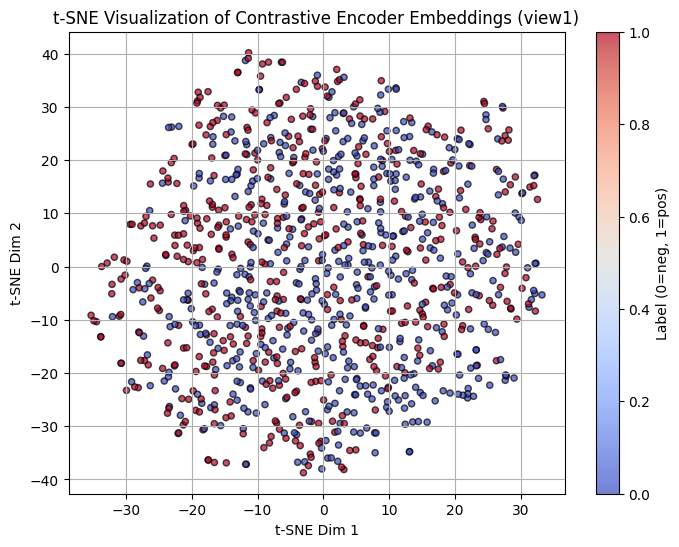


 view1-view2 임베딩 차이 (평균 거리): 3.8279462


In [7]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# contrastive로 학습된 encoder 불러오기
model = AutoModel.from_pretrained(
    r"D:\labeled_fintuned_model",
    local_files_only=True
).to("cuda")
encoder_state_dict = torch.load("contrastive_encoder.pt")
model.load_state_dict(encoder_state_dict)
model.eval()

# tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    r"D:\labeled_fintune_model",
    local_files_only=True
)

# 데이터셋 불러오기 (랜덤 섞어서 1000개 샘플 사용)
dataset = load_dataset("imdb")
dataset = dataset["test"].shuffle(seed=42).select(range(1000))
texts = dataset["text"]
labels = dataset["label"]

print(" 실제 라벨 종류:", set(labels))  # 0과 1 둘 다 있는지 확인

# 토크나이즈
inputs = tokenizer(texts, truncation=True, padding="max_length", max_length=128, return_tensors="pt").to("cuda")

# view1 embedding (dropout ON)
model.train()  # dropout 활성화
with torch.no_grad():
    outputs1 = model(**inputs)
    embeds1 = outputs1.pooler_output.cpu().numpy()

# view2 embedding (다시 dropout ON → augmentation)
model.train()
with torch.no_grad():
    outputs2 = model(**inputs)
    embeds2 = outputs2.pooler_output.cpu().numpy()

# t-SNE 시각화
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeds1_2d = tsne.fit_transform(embeds1)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embeds1_2d[:, 0], embeds1_2d[:, 1],
    c=labels, cmap="coolwarm", alpha=0.7, s=20, edgecolors="k"
)
plt.colorbar(scatter, label="Label (0=neg, 1=pos)")
plt.title("t-SNE Visualization of Contrastive Encoder Embeddings (view1)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.show()

# view1 vs view2 차이도 확인
diff = np.linalg.norm(embeds1 - embeds2, axis=1)
print("\n view1-view2 임베딩 차이 (평균 거리):", diff.mean())


In [12]:
# 코사인 유사도 계산
embeds1_norm = embeds1 / np.linalg.norm(embeds1, axis=1, keepdims=True)
embeds2_norm = embeds2 / np.linalg.norm(embeds2, axis=1, keepdims=True)

cos_sim = (embeds1_norm * embeds2_norm).sum(axis=1)  # (1000, )
mean_cos_sim = cos_sim.mean()

print(f"view1-view2 평균 Cosine Similarity: {mean_cos_sim:.4f}")

view1-view2 평균 Cosine Similarity: 0.9298


 view1: 같은 입력 데이터지만 dropout, data augmentation 등의 변형을 통해 얻은 첫 번째 표현<br>
 view2: 같은 입력 데이터지만 다른 변형을 통해 얻은 두 번째 표현<br>
 view1-view2 임베딩이 가까운 모습을 보이며 Cosine Similarity: 0.9298로 높게 측정

<hr>



## Downstream Fine-tuning (Supervised Phase)

Contrastive pre-trained encoder를 labeled IMDb 데이터로 fine-tuning
<br>
#### Encoder 상위 2개 layer만 학습
* Pre-trained encoder의 강력한 표현력 활용
* 불필요한 과적합 방지
* 언어 표현의 세분화와 task-specific tuning
    * transformer encoder의 하위 layer (1~9): 문법/구문 같은 언어의 기본 구조를 학습
    * transformer encoder의 상위 layer (10~11): 특정 task (감정 분석, 문장 유사도 등)에 맞는 정교한 표현을 학습

* LoRA 적용 :
    * encoder의 일부 query, value에만 low-rank adapter 추가 → 파라미터 효율적으로 fine-tuning

* labeled data를 사용하여 classification head를 학습
    

In [8]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from peft import get_peft_model, LoraConfig, TaskType
import torch
from datasets import load_dataset
from transformers import AutoTokenizer

# Model 준비
model_cls = AutoModelForSequenceClassification.from_pretrained(
    r"D:\labeled_fintuned_model",
    local_files_only=True
).to("cuda")

# contrastive encoder 가중치 덮어쓰기
encoder_state_dict = torch.load("contrastive_encoder.pt")
model_cls.bert.load_state_dict(encoder_state_dict)

# Encoder 일부 Layer unfreeze (마지막 2개 layer)
for name, param in model_cls.bert.named_parameters():
    if "encoder.layer.10" in name or "encoder.layer.11" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# LoRA 설정 (dropout↑)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)
model_cls = get_peft_model(model_cls, lora_config)
print("\n 적용된 LoRA 파라미터 (encoder 일부 unfreeze):")
model_cls.print_trainable_parameters()

# 데이터셋
dataset = load_dataset("imdb")
train_dataset = dataset["train"]

tokenized_train = train_dataset.map(
    lambda e: tokenizer(e["text"], truncation=True, padding="max_length", max_length=128),
    batched=True
).rename_column("label", "labels").remove_columns(["text"])
tokenized_train.set_format(type="torch")

tokenized_test = dataset["test"].map(
    lambda e: tokenizer(e["text"], truncation=True, padding="max_length", max_length=128),
    batched=True
).rename_column("label", "labels").remove_columns(["text"])
tokenized_test.set_format(type="torch")

# Metric
def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, f1_score
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# TrainingArguments
training_args = TrainingArguments(
    output_dir="./results_lora_encoderfreeze_minimal",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=4,  
    fp16=True 
)

# Trainer
trainer = Trainer(
    model=model_cls,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Training
trainer.train()

# 최종 평가
eval_results = trainer.evaluate()
print("\n 최종 성능 평가 결과:")
for metric, value in eval_results.items():
    print(f"{metric}: {value:.4f}")



 적용된 LoRA 파라미터 (encoder 일부 unfreeze):
trainable params: 296,450 || all params: 109,780,228 || trainable%: 0.2700


C:\Users\gnssl\AppData\Local\Temp\ipykernel_16720\2821546221.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
D:\inteXvenv\lib\site-packages\transformers\utils\generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, d

Step,Training Loss
500,0.247400
1000,0.159600
1500,0.148400
2000,0.148300
2500,0.143500
3000,0.140900


D:\inteXvenv\lib\site-packages\transformers\utils\generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(obj)
D:\inteXvenv\lib\site-packages\transformers\utils\generic.py:271: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(obj)
D:\inteXvenv\lib\site-packages\transformers\utils\generic.py:271: FutureWarning: The input object of typ


 최종 성능 평가 결과:
eval_loss: 0.3212
eval_accuracy: 0.8880
eval_f1: 0.8879
eval_runtime: 43.2665
eval_samples_per_second: 577.8140
eval_steps_per_second: 18.0740
epoch: 4.0000


D:\inteXvenv\lib\site-packages\transformers\utils\generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(obj)
D:\inteXvenv\lib\site-packages\transformers\utils\generic.py:271: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(obj)


              precision    recall  f1-score   support

    negative       0.89      0.89      0.89     12500
    positive       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



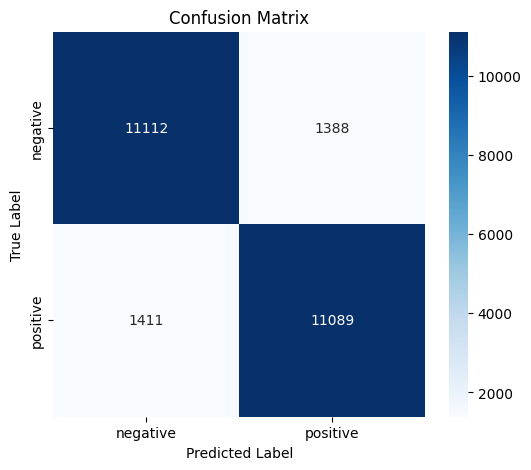

In [11]:


# 예측값
preds_logits = trainer.predict(tokenized_test).predictions
preds = preds_logits.argmax(axis=1)
labels = tokenized_test["labels"]

cm = confusion_matrix(labels, preds)
report = classification_report(labels, preds, target_names=["negative", "positive"])

# 출력
print(report)

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 한계점
1. Unsupervised 데이터 활용의 한계성 
<br>
본 과제에서는 IMDB 데이터셋의 unlabeled 데이터를 활용해 contrastive learning을 수행했으나, 다른 self-supervised 기법이나 semi-supervised 방식(pseudo-labeling 등)과 비교 실험을 진행하지 않아 contrastive learning의 효과를 상대적으로 검증하기 어려웠습니다. 결과적으로 contrastive learning의 성능(0.886 F1-score)이 pre-trained 모델 성능(0.9122)보다 낮아졌는데, 이러한 현상이 unlabeled 데이터 활용 방식의 한계로 보입니다.
2. 하이퍼파라미터 최적화 부족
<br>
contrastive learning의 성능은 temperature, batch size, augmentation 방식 등에 크게 좌우됩니다. 그러나 이러한 파라미터들의 최적화를 위한 실험이 이루어지지 않아, contrastive learning의 잠재 성능을 충분히 발휘하지 못했을 가능성이 큽니다. downstream task에서 성능이 저하된 부분도 이와 관련이 있을 수 있습니다.
3. Downstream task 최적화의 미흡
<br>
contrastive learning이 encoder의 표현력을 높여주었을 가능성은 있지만, sentiment analysis라는 특정 downstream task에 맞춰 encoder의 특화된 feature가 일부 희생되었을 수 있습니다.<br>
또한 downstream task의 성능 저하를 방지하기 위한 추가적인 fine-tuning이나 task-specific 조정이 없었습니다. 
4. 여러번의 fine-tunning으로 인한 과적합 위험성
<br>
pre-trained 모델 → labeled 데이터 fine-tuning → contrastive learning (unsupervised 데이터) → downstream task fine-tuning (LoRA 활용)
이처럼 fine-tuning이 많아지면, encoder가 특정 데이터셋(IMDB) 구조나 편향에만 지나치게 최적화될 위험 존재

<hr>

# References
* Gao, T., Yao, X., & Chen, D. (2021). SimCSE: Simple contrastive learning of sentence embeddings. Proceedings of the 2021 Conference on Empirical Methods in Natural Language Processing (EMNLP)
* Tsai, A. C.-Y., Lin, S.-Y., & Fu, L.-C. (2021). Contrast-enhanced semi-supervised text classification with few labels. Proceedings of the 2021 Conference of the North American Chapter of the Association for Computational Linguistics (NAACL).
* Chen, J., Yang, Z., & Yang, D. (2020). MixText: Linguistically-informed interpolation of hidden space for semi-supervised text classification. Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP).
* Grill, J.-B., Strub, F., Altché, F., Tallec, C., Richemond, P. H., Buchatskaya, E., Doersch, C., Avila Pires, B., Guo, Z. D., Azar, M. G., Piot, B., Kavukcuoglu, K., Munos, R., & Valko, M. (2020). Bootstrap your own latent: A new approach to self-supervised learning. Advances in Neural Information Processing Systems (NeurIPS)
<hr>
* https://applepy.tistory.com/38
* https://hul980.tistory.com/117
* https://wikidocs.net/24586